# 1 - Open Exploration (Scenarios)

# Table of Contents
* [Exploratory Analysis](##chapter1)
    * [Import model](#section_1_1)
    * [Business as Usual (BAU) Analysis](#section_1_2)
        * [Random Trees](#section_1_2_1)
        * [SOBOL](#section_1_2_2)
        * [Reference Scenario Creation](#section_1_2_3)
    * [Random Policies](#section_1_3)
    * [Selected Policies](#section_1_4)

* [PRIM](#chapter2)
    * [Random Policies against MWL](#section_2_1)
    * [Selected Policies against MWL](#section_2_2)


In [1]:
#TODO: Remove this cell when the code is stable
# This script sets a fixed random seed for reproducibility in experiments.
import numpy as np
import random

np.random.seed(42)
random.seed(42)

## 1. Exploratory Analysis  <a class="anchor" id="chapter1"></a>

In this section, we apply scenario discovery to identify the uncertainty space. Our aim is to maximize the minimum water level in the system. 
We will use Problem formulation 2. We have previously added the Minimum Water Level as an outcome in [Problem Formulation](problem_formulation.py) by adding the function min_over_pf2.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import pickle


from ema_workbench import MultiprocessingEvaluator
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import load_results



In [3]:
# Importing EMA workbench
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.parameters import Constant
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring, RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

#### Import model  <a class="anchor" id="section_1_1"></a>

In [4]:
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
#for policy in dike_model.levers:
    #³print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

#### Business as Usual Analysis: Global sensitivity using  Random Trees + SOBOL <a class="anchor" id="section_1_2"></a>

Check what are the most uncertain parameters in the status quo (no policies). As for outcomes, we have a special focus on the Minimum water level outcome. 
We will focus afterwards on these parameters

In [5]:
# Create a dictionary with the names of the levers and their values set to 0
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policy_BAU = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    )]

#### Random Trees <a class="anchor" id="section_1_2_1"></a>

In [ ]:
# TODO: @amaryllis to run it with more scenarios


# Runs the experiments with BAU, which is the do-nothing policy
# and uses Latin Hypercube Sampling (LHS) for uncertainty sampling
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_BAU = evaluator.perform_experiments(scenarios=50000,policies=policy_BAU,uncertainty_sampling=Samplers.LHS)

experiments_BAU, outcomes_BAU = results_BAU

[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 50000 scenarios * 1 policies * 1 model(s) = 50000 experiments
100%|████████████████████████████████████| 50000/50000 [10:19<00:00, 80.67it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
experiments_BAU.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

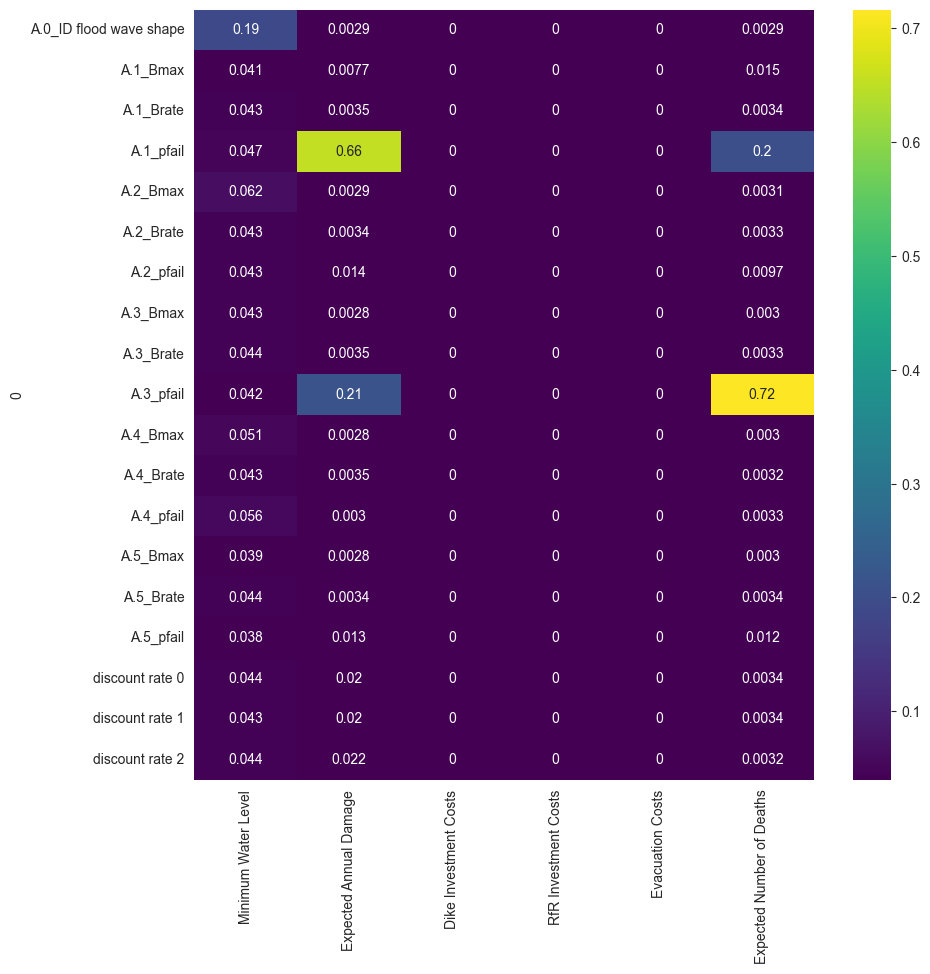

In [ ]:
# Selects the columns that contain the uncertainties
experiments_unc =experiments_BAU.iloc[:,0:19]

# Change outcomes to df 
df = pd.DataFrame(outcomes_BAU) 

# Calculates and plots the feature scores
x = experiments_unc
y = df
fig, ax = plt.subplots(figsize=(10,10))
fs = feature_scoring.get_feature_scores_all(x, y,)
sns.heatmap(fs, cmap="viridis", annot=True,vmin=0.04)
plt.show()

In [ ]:
# Selects the 20% percentage the worst outcomes for Transport company's goals
worse_outcome_target = df["Minimum Water Level"] <= list(np.sort(df["Minimum Water Level"]))[np.int64(0.20* len(df["Minimum Water Level"]))]

In [ ]:
# Calculates feature scores for the worst outcomes for the general situation.
# Which uncertainties are most important for the worst outcomes?
fs, alg = feature_scoring.get_ex_feature_scores(x, worse_outcome_target, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.0_ID flood wave shape,0.306094
discount rate 1,0.042021
discount rate 2,0.041098
discount rate 0,0.040534
A.5_Brate,0.040316
A.2_Brate,0.039120
A.4_Brate,0.038940
A.3_Brate,0.038296
A.3_pfail,0.038175


In [ ]:
# Discard the names of uncertainties that are not important for the worst outcomes
#unc = fs[fs[1] > 0.04] #TODO why 0.04
#unc


#### Sobol Analysis <a class="anchor" id="section_1_2_2"></a>

Performing the Sobol Analysis

In [ ]:
# # I added this because the results saved from the filtered one doesn't work on the prim
# dike_model_2, planning_steps = get_model_for_problem_formulation(2)
# #TODO: @amaryllis to run it with more scenarios	to 8400
#
# # Runs the experiments with fewer uncertainties and SOBOL sampling, which results in 151200 experiments, because there are 8 uncertainties
# with MultiprocessingEvaluator(dike_model_2) as evaluator:
#     results4 = evaluator.perform_experiments(scenarios=1000,policies=policy_BAU,uncertainty_sampling=Samplers.SOBOL)
#
# experiments4, outcomes4 = results4
#
# import pickle
# with open('./data/sobol_results.pkl', 'wb') as file:
#     pickle.dump(results4, file)

[MainProcess/INFO] pool started with 14 workers
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments

100%|████████████████████████████████████| 40000/40000 [09:15<00:00, 72.01it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
dike_model_2, planning_steps = get_model_for_problem_formulation(2)

# Will contain uncertainties that need to be made constant
dele = []
# Cycle over levers and add levers to dele if they need to be constant
for x in dike_model_2.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail", "discount rate 0","discount rate 1","discount rate 2", "A.1_Bmax", "A.2_Bmax", "A.3_Bmax", "A.4_Bmax", "A.5_Bmax","A.1_Brate", "A.2_Brate", "A.3_Brate", "A.4_Brate","A.5_Brate"]:
        dele.append(x.name)

# Remove uncertainties that are in dele
for i in dele:
    dike_model_2.uncertainties.__delitem__(i)

# Make the deleted uncertainties constant
constant_entries = [
    Constant('A.0_ID flood wave shape', 30)]
    # Constant('A.1_Bmax', 190), Constant('A.1_Brate', 1.5),
    # Constant('A.2_Bmax', 190), Constant('A.2_Brate', 1.5),
    # Constant('A.3_Bmax', 190), Constant('A.3_Brate', 1.5),
    # Constant('A.4_Bmax', 190), Constant('A.4_Brate', 1.5),
    # Constant('A.5_Bmax', 190), Constant('A.5_Brate', 1.5)]

    # Add the uncertainties as constants
for var in constant_entries:
    dike_model_2.constants.extend(var)

In [ ]:
#TODO: @amaryllis to run it with more scenarios	to 8400!!


# Runs the experiments with fewer uncertainties and SOBOL sampling, which results in 151200 experiments, because there are 8 uncertainties
with MultiprocessingEvaluator(dike_model_2) as evaluator:
    results3 = evaluator.perform_experiments(scenarios=3000,policies=policy_BAU,uncertainty_sampling=Samplers.SOBOL)

experiments3, outcomes3 = results3

[MainProcess/INFO] pool started with 14 workers
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 114000 scenarios * 1 policies * 1 model(s) = 114000 experiments
100%|██████████████████████████████████| 114000/114000 [24:00<00:00, 79.14it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
#Saving results AFTER filtering
with open('./data/SOBOL_filtered_Scen_result.pkl', 'wb') as file:
    pickle.dump(results3, file)

In [ ]:
# Change outcomes to df 
df = pd.DataFrame(outcomes3)
df

,Minimum Water Level,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,4.898669,1.950861e+09,0,0.0,0.0,3.387457
1,4.880830,1.950861e+09,0,0.0,0.0,3.387457
2,4.898669,1.950861e+09,0,0.0,0.0,3.387457
3,5.112453,2.476435e+09,0,0.0,0.0,3.740152
4,4.795428,1.950861e+09,0,0.0,0.0,3.387457
...,...,...,...,...,...,...
113995,5.026893,2.862871e+09,0,0.0,0.0,3.169502
113996,5.026893,2.432319e+09,0,0.0,0.0,3.169502
113997,5.026893,3.041014e+09,0,0.0,0.0,3.169502
113998,5.026893,3.041014e+09,0,0.0,0.0,3.169502


In [ ]:
problem = get_SALib_problem(dike_model_2.uncertainties)
# Remove columns which are not useful for the scenario sensitivity
df.drop(columns=["Evacuation Costs","Dike Investment Costs", "RfR Investment Costs"],inplace=True)

/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


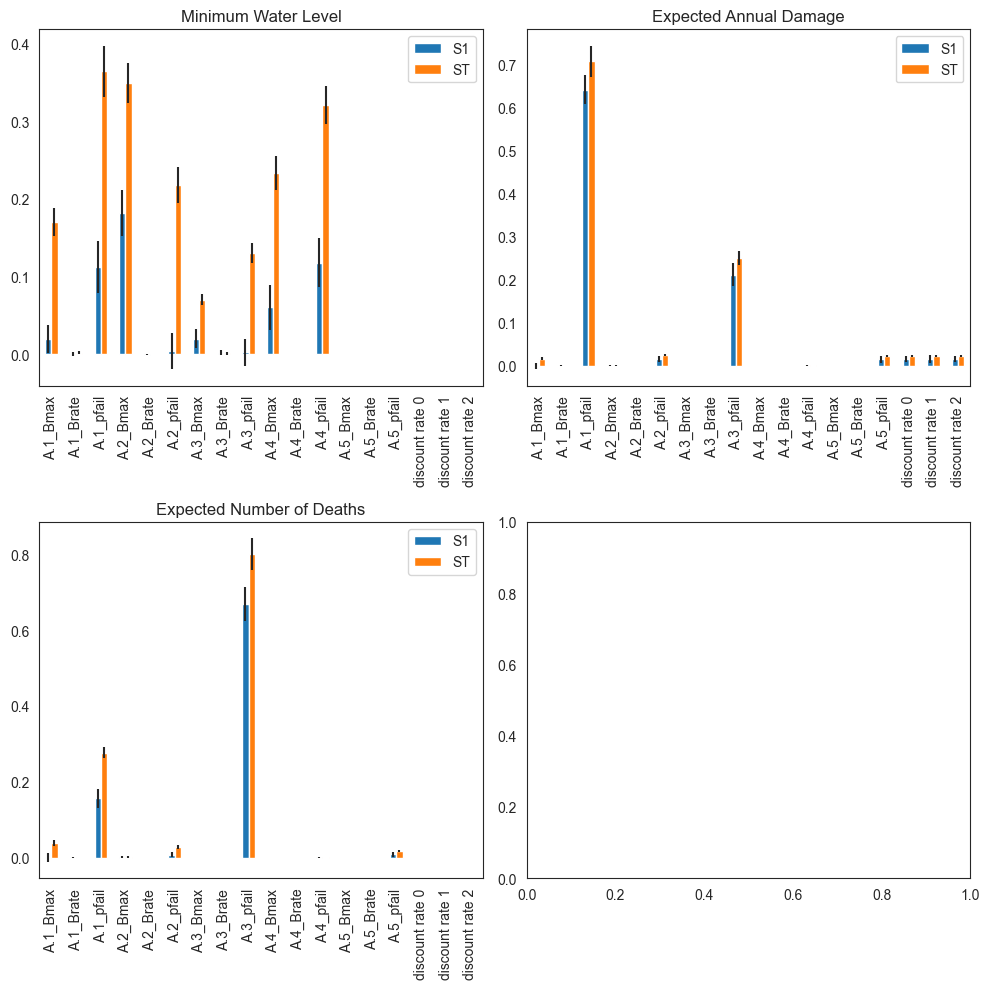

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
# loops over outcomes
for index,kpi in enumerate(df.columns):
    #Calculates sobol scores
    Si = sobol.analyze(problem,np.array(outcomes3[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

#### Create reference scenario with outcomes of SOBOL<a class="anchor" id="section_1_2_3"></a>
The reference scenario is a "worst-case" scenario


In [ ]:
#use outcomes of SOBOL (should be changed to filtered)
with open('./data/SOBOL_filtered_Scen_result.pkl', 'rb') as file: #sobol_results
    loaded_data = pickle.load(file)

# Divides the loaded data into experiment and outcome data
x =loaded_data[0]
df =pd.DataFrame(loaded_data[1])

In [ ]:
# Perform PRIM to get reference scenario

target = (
    (df['Minimum Water Level'] < 5) )

print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

56522
114000
[False  True]


[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 114000 points remaining, containing 56522 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05769298245614035, coverage: 0.11636177063798167, density: 1.0 restricted_dimensions: 4


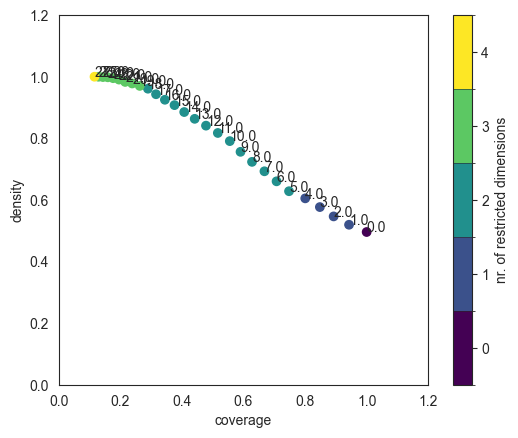

In [ ]:
prim_alg = prim.Prim(x, target, threshold=0.8, peel_alpha=0.1)
box_experiments = prim_alg.find_box()

box_experiments.show_tradeoff(annotated=True)
plt.show()

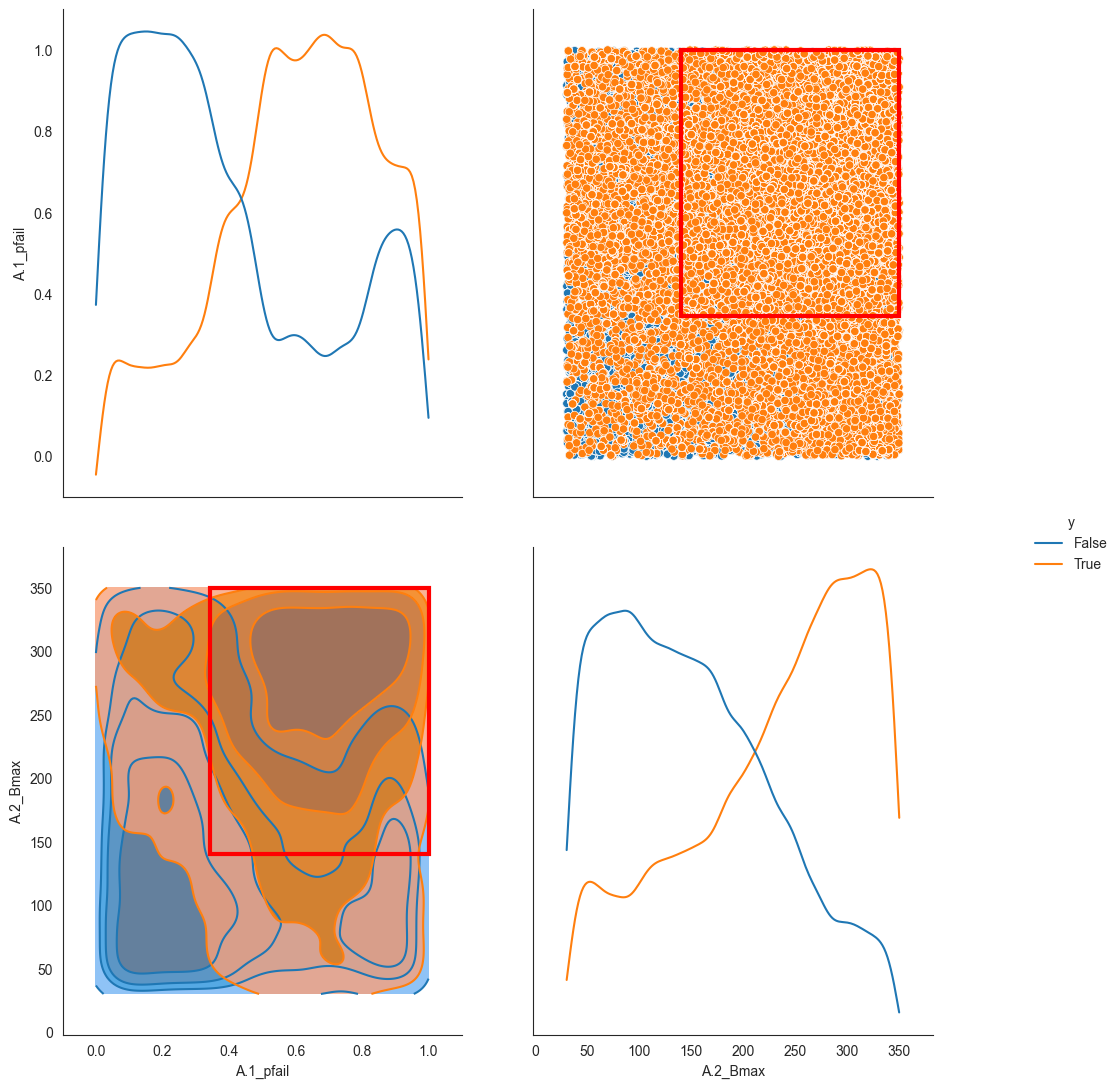

In [ ]:
# Show the distribution between samples and the prim boundaries
point_ref = 8
box_experiments.select(point_ref)
box_experiments.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

coverage        0.627826
density         0.723569
id              8.000000
k           35486.000000
mass            0.430202
mean            0.723569
n           49043.000000
res_dim         2.000000
Name: 8, dtype: float64

                box 8                              
                  min         max qp value qp value
A.1_pfail    0.344300    0.999839      0.0      NaN
A.2_Bmax   140.102774  349.999858      0.0      NaN



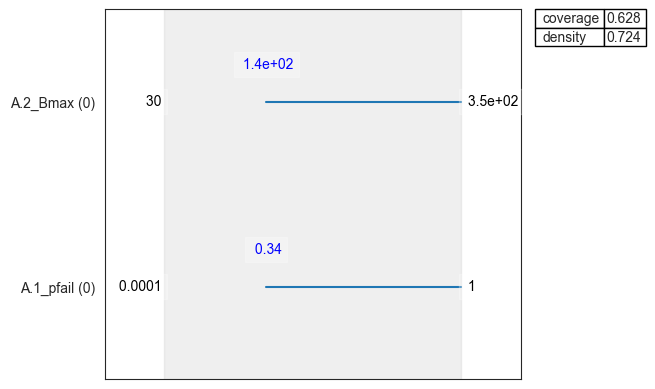

In [ ]:
# Show prim statistics
box_experiments.inspect(point_ref)

# Plot boundaries prim in graph
box_experiments.inspect(point_ref, style="graph")
plt.show()

In [ ]:
# Saves the boundary data of prim
pd.DataFrame(box_experiments.inspect(point_ref, style='data')[0][1]).to_csv('./data/para_space_all.csv')

In [ ]:
import pandas as pd
import pickle
from ema_workbench import Scenario
from problem_formulation import get_model_for_problem_formulation  # Ensure this exists

# Load the PRIM box boundaries
df_param_space_all = (
    pd.read_csv('./data/para_space_all.csv')
    .drop(0)  # Drops the duplicated header row
    .rename(columns={"Unnamed: 0": "Variable"})
)

# Get the model and uncertainties
dike_model, planning_steps = get_model_for_problem_formulation(2)

def create_scenario_from_box():
    """Creates a Scenario using the midpoint values from the PRIM box boundaries."""
    para_list = []

    for uncertainty in dike_model.uncertainties:
        variable = uncertainty.name

        if variable in df_param_space_all.Variable.values:
            min_val = float(df_param_space_all[df_param_space_all['Variable'] == variable].iloc[0, 1])
            max_val = float(df_param_space_all[df_param_space_all['Variable'] == variable].iloc[0, 2])
            para_list.append((min_val + max_val) / 2)
        #elif variable.endswith("Bmax"):  # Discount rate
            #para_list.append(190)
        elif variable == "A.0_ID flood wave shape":
            para_list.append(30)
        #elif variable.endswith("Brate"):
            #para_list.append(1.5)
        else:
            # Default: midpoint of the full uncertainty range
            para_list.append(
                uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2
            )

    # Debug print: Check the lists before zipping
    print("Uncertainty names:", [u.name for u in dike_model.uncertainties])
    print("Parameter values:", para_list)

    # Create a dict of {uncertainty name: value}
    scenario_data = dict(zip([u.name for u in dike_model.uncertainties], para_list))

    # Debug print: Check the final scenario_data dict
    print("Scenario data:", scenario_data)

    # Create a Scenario with that dict and a name (use ** to unpack the dictionary into keyword arguments)
    return Scenario("PRIM_Midpoint", **scenario_data)

# Create the scenario
reference_scenario = [create_scenario_from_box()]

# Save to .pkl
#with open("./data/reference_scenario", "wb") as file:
    #pickle.dump(reference_scenario, file)

Uncertainty names: ['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']
Parameter values: [1.5, 1.5, 1.5, 30, 190.0, 0.6720691719092429, 1.0, 245.05131609737873, 0.5, 1.0, 190.0, 0.5, 1.0, 190.0, 0.5, 1.0, 190.0, 0.5, 1.0]
Scenario data: {'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5, 'A.0_ID flood wave shape': 30, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.6720691719092429, 'A.1_Brate': 1.0, 'A.2_Bmax': 245.05131609737873, 'A.2_pfail': 0.5, 'A.2_Brate': 1.0, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.5, 'A.3_Brate': 1.0, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5, 'A.4_Brate': 1.0, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1.0}


In [ ]:
# Save as CSV to check
# Convert the scenario data to a DataFrame
scenario_df = pd.DataFrame([reference_scenario])

# Save to CSV
#scenario_df.to_csv("./data/reference_scenario.csv", index=False)
print(reference_scenario)

[Scenario({'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5, 'A.0_ID flood wave shape': 30, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.6720691719092429, 'A.1_Brate': 1.0, 'A.2_Bmax': 245.05131609737873, 'A.2_pfail': 0.5, 'A.2_Brate': 1.0, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.5, 'A.3_Brate': 1.0, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5, 'A.4_Brate': 1.0, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1.0})]


### Random policies <a class="anchor" id="section_1_3"></a>
First, we explore the lever space by sampling random lever combinations (policies)

We are going to address the worst possible combinations, so our client can avoid them. We do this to have a first picture.

We have to keep in mind that some combinations may be absurd, (RfR in 2020 On and RfR in 2025 off, nonsense)

Output: Worst case scenarios that make sense

In [9]:
# enlisting outcomes
for outcome in dike_model_2.outcomes:
    print(repr(outcome))

ScalarOutcome('Minimum Water Level', variable_name=('A.1_Water Level', 'A.2_Water Level', 'A.3_Water Level', 'A.4_Water Level', 'A.5_Water Level'), function=<function min_over_pf2 at 0x11de5b740>)
ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x11de5b560>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x11de5b560>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x11de5b560>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x11de5b560>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_

In [10]:
# ---Run  experiments with random combination of levers and plot results---
ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 2000
policies = 10

with MultiprocessingEvaluator(dike_model_2) as evaluator:
    random_results = evaluator.perform_experiments(scenarios, policies = policies, uncertainty_sampling = Samplers.LHS)

random_experiments, random_outcomes = random_results


[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 2000 scenarios * 10 policies * 1 model(s) = 20000 experiments
100%|████████████████████████████████████| 20000/20000 [03:58<00:00, 83.72it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
random_experiments_df = pd.DataFrame(random_experiments)
random_experiments_df

random_cleaned_experiments = random_experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)

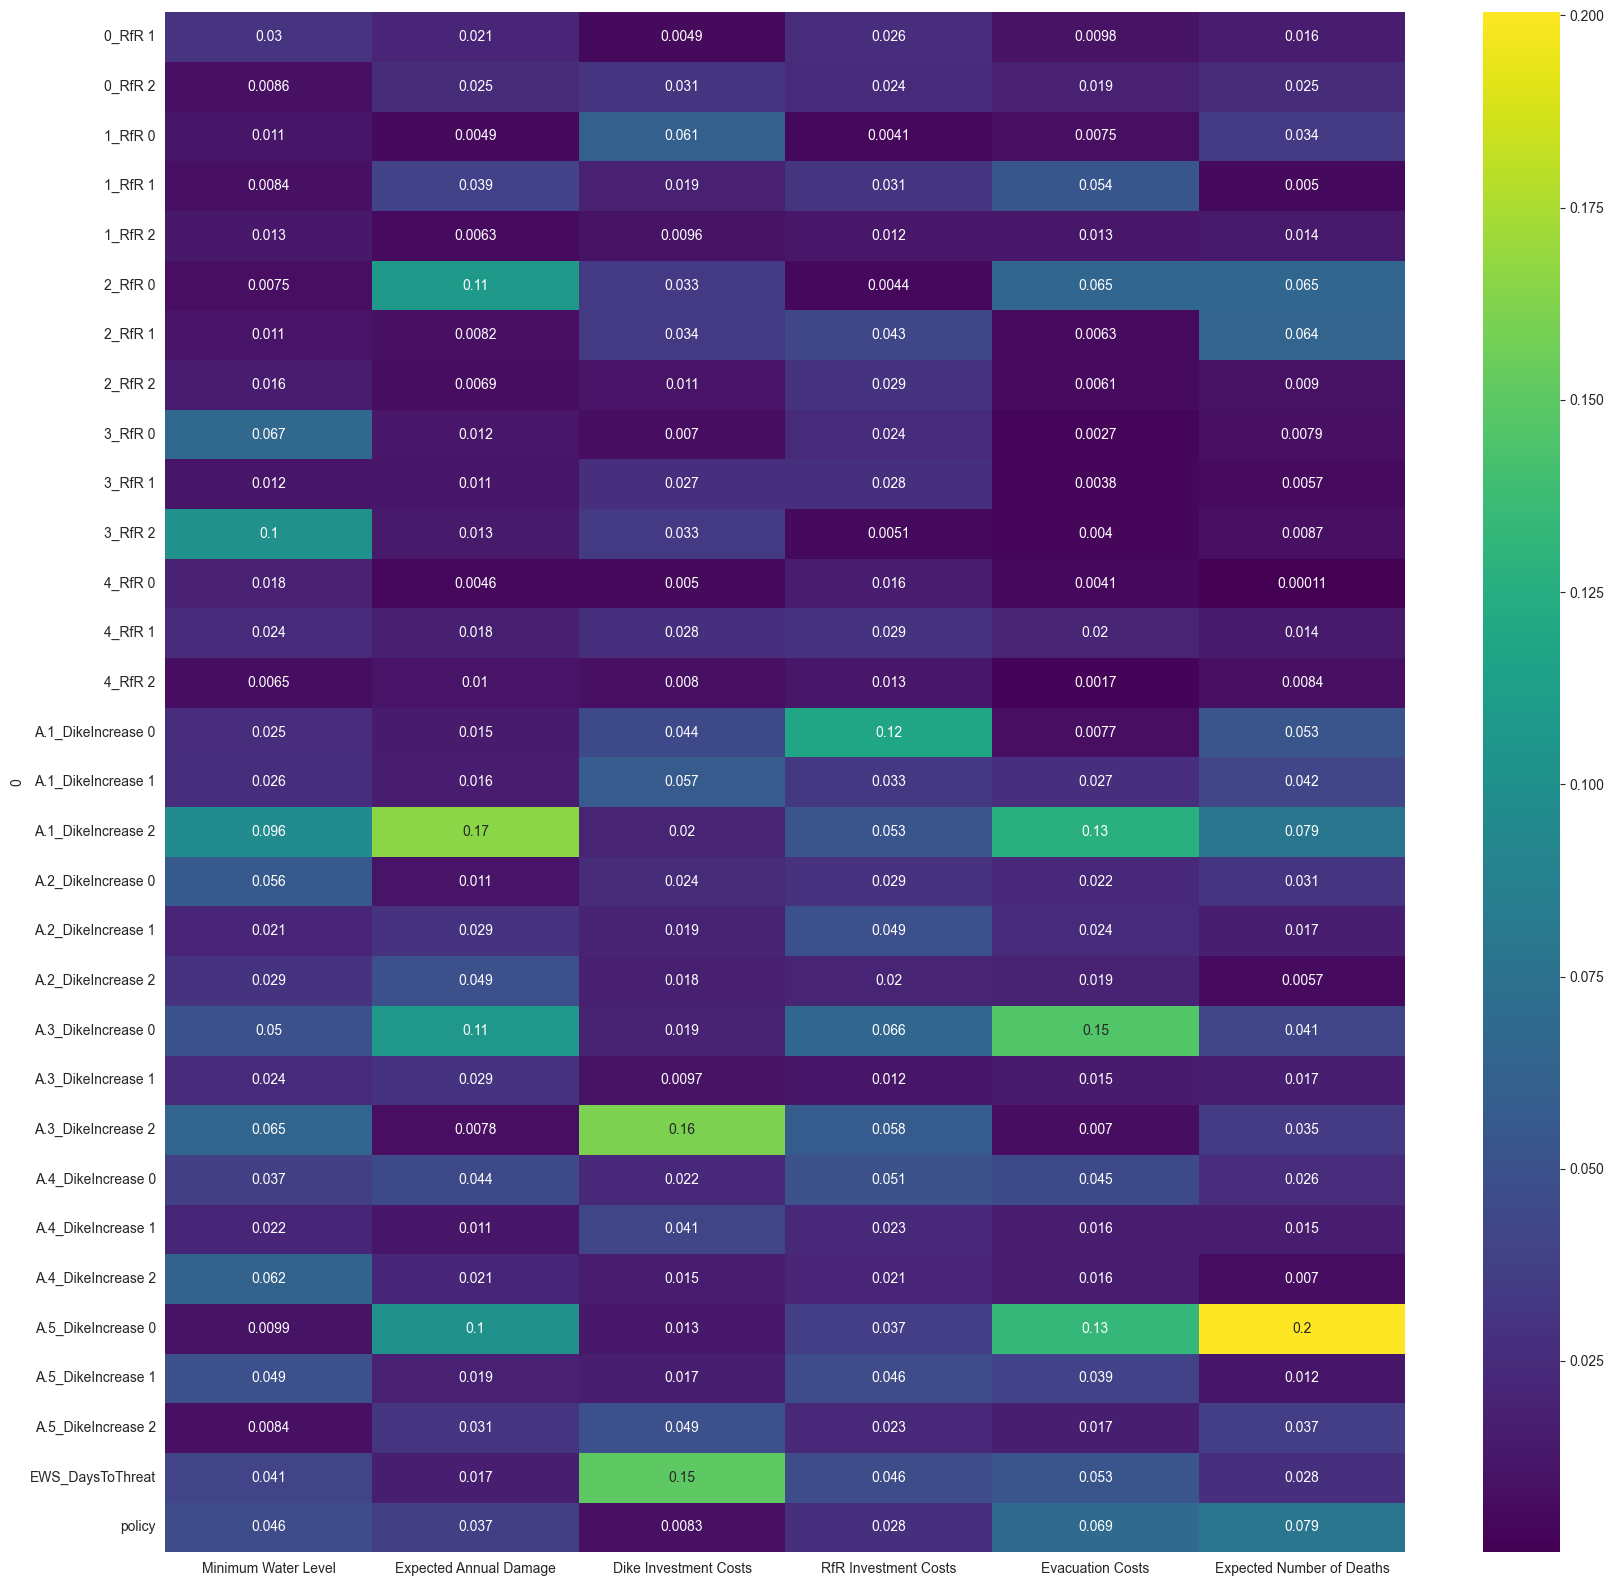

In [11]:
# Selects the columns that contain the levers
experiments_unc = random_experiments.iloc[:, 19:]

# Change outcomes to df
df = pd.DataFrame(random_outcomes)

# Calculates and plots the feature scores
x = experiments_unc
y = df
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()

[MainProcess/INFO] no time dimension found in results


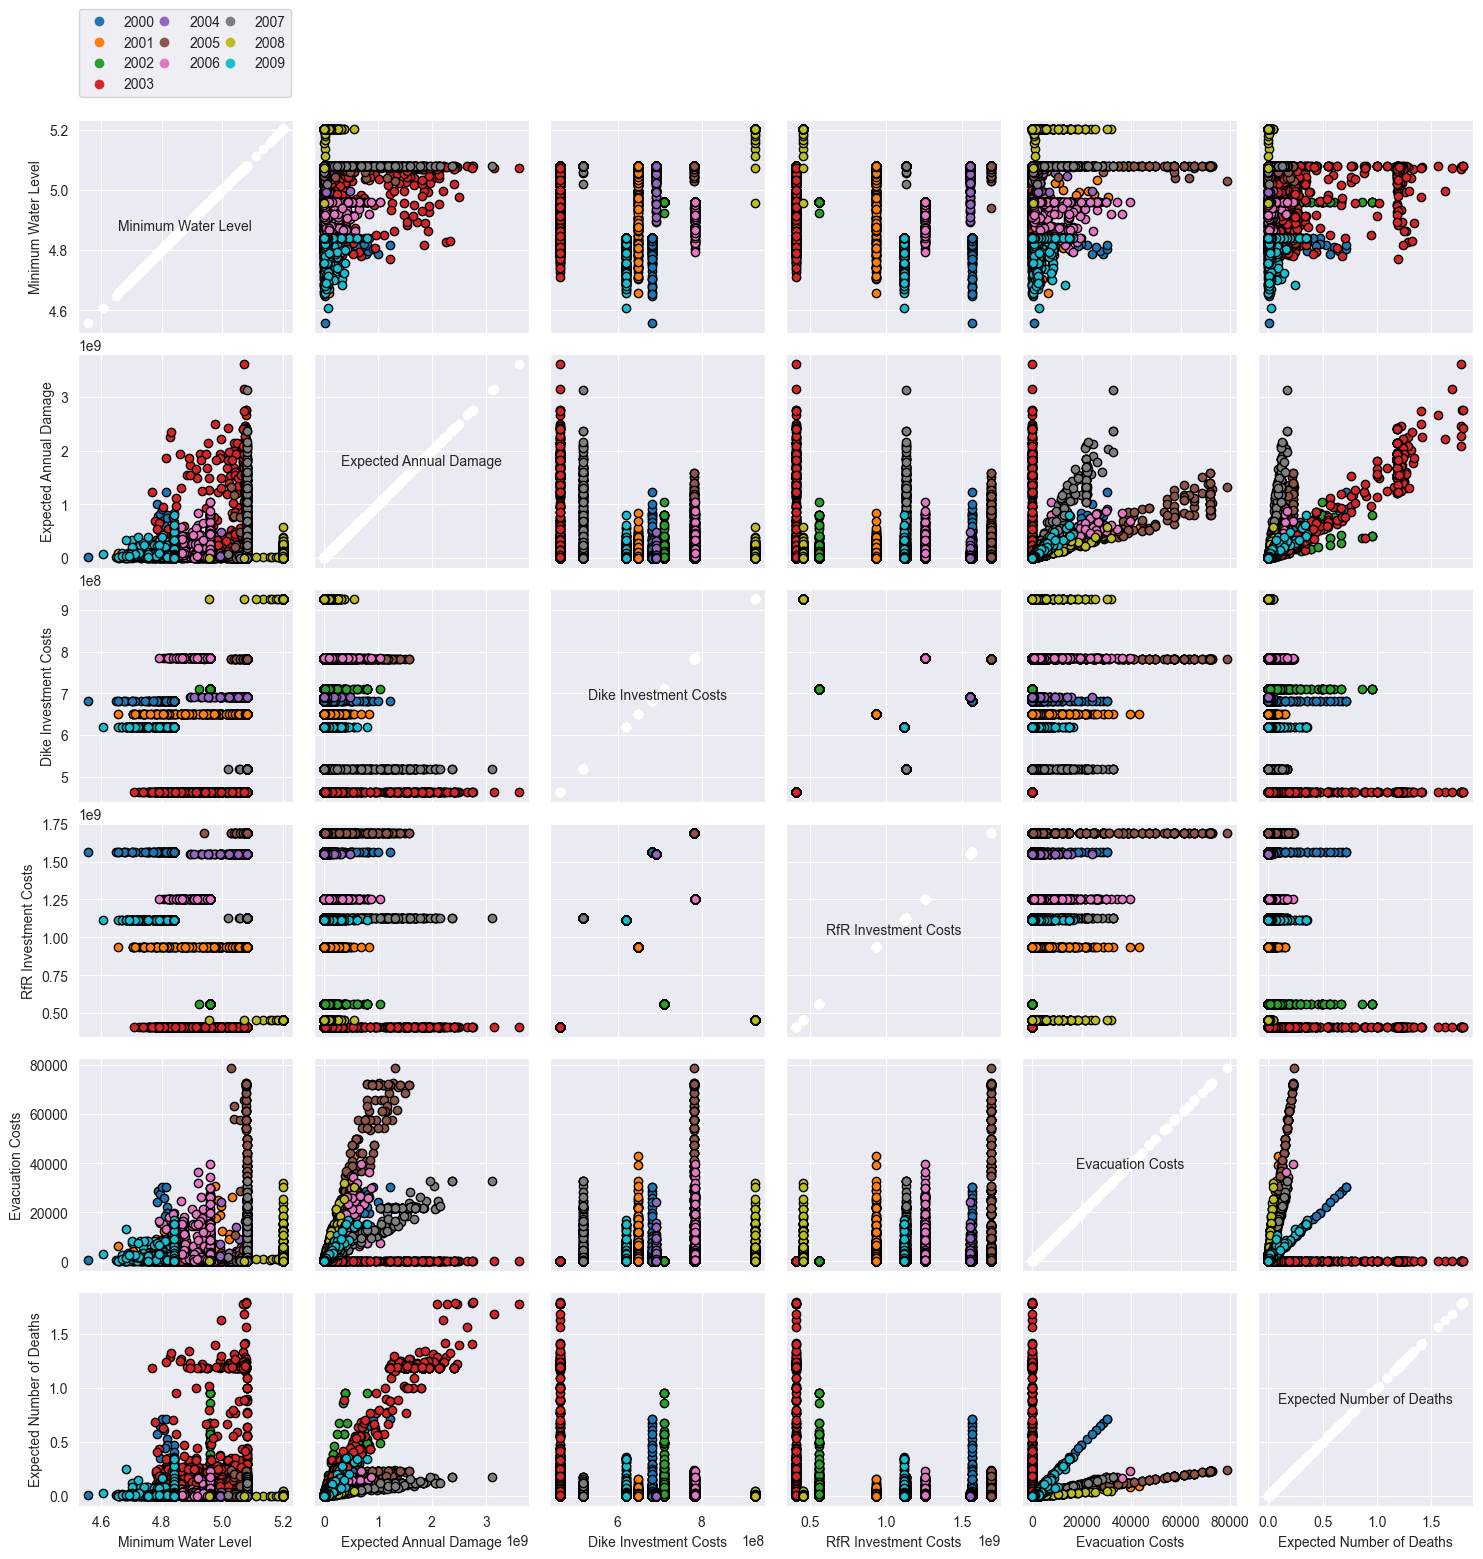

In [11]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(random_experiments, random_outcomes,group_by='policy', legend=True, figsize=(10, 10))
fig.set_size_inches(18, 18)
plt.show()

In [ ]:
#TODO: Interpret the results

In [12]:
from ema_workbench import save_results
save_results(random_results, 'results_ 100 scenarios_10 policies.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/amaryllisbrosens/PycharmProjects/MBDM-Group-1/results_ 100 scenarios_10 policies.tar.gz


### Selected policies <a class="anchor" id="section_1_4"></a>
Now, we are going to test several policies that were discussed during the first debate. Analyzing these policies will provide us a first big picture of the system.

The policies that will be studied are: 

0. Business as usual (BAU)

From [problem_formulation](problem_formulation.py) 's default:
1. policy 1 is about extra protection in upper boundary
2. policy 2 is about extra protection in lower boundary
3. policy 3 is extra protection in random locations

From the first debate: 

4. Room for the River in Doesburg (A1) and Zuthpen (A3)
5. Room for the River in  Doesburg (A1) and Zuthpen (A3) + dike heightening of 5 meters in Cortenoever (A2) and Gorssel (A4) in time decision 0


Outcome of this section: which are the best policies only focusing on water level

In [28]:
# NEW POLICIES WITH TIME
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_open_exp = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "P1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "P2",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "P3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
    #RFR in Doesburg (Haviker: 1RfR) and Zuthpen (Tichelbeekse 2RfR) as they talked about in the debate
    Policy(
        "P4",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "2_RfR 0": 1, "2_RfR 1": 1, '2_RfR 2': 1,}
        )
    ),

        #RFR in Zuthpen
    Policy(
        "P5",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 0, "1_RfR 2": 0,
               "2_RfR 0": 1, "2_RfR 1": 1, '2_RfR 2': 1,}
        )
    ),

        #RFR in Doesburg
    Policy(
        "P6",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 0, "3_RfR 1": 0, '3_RfR 2': 0,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "P7",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for 1RfR
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for 2RfR
            "2_RfR 0": 1, "2_RfR 1": 1, "2_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0})),

    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "P8",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
               "2_RfR 0": 0, "2_RfR 1": 1, '2_RfR 2': 1,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "P9",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "2_RfR 0": 0, "2_RfR 1": 1, "2_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 0, "2_DikeIncrease 1": 5, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0})),

    #RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "P10",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0})),

        Policy(
        "P11",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),
        #RFR in all location
     Policy(
        "P12",
        **dict(
            get_do_nothing_dict(),
            **{
            "0_RfR 0": 1, "1_RfR 0": 1, "2_RfR 0": 1,
            "3_RfR 0": 1, "4_RfR 0": 1})),

            #RFR in all location
     Policy(
        "P13",
        **dict(
            get_do_nothing_dict(),
            **{
            "0_RfR 0": 1, "2_RfR 0": 1, "1_DikeIncrease 0": 5,
            "4_DikeIncrease 0": 7, "5_DikeIncrease 0": 8 }))

]

In [29]:

# pass the policies list to EMA workbench experiment runs
n_scenarios = 2000
with MultiprocessingEvaluator(dike_model_2) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_open_exp)



[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 2000 scenarios * 14 policies * 1 model(s) = 28000 experiments
100%|████████████████████████████████████| 28000/28000 [05:41<00:00, 82.08it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [30]:
experiments, outcomes = results

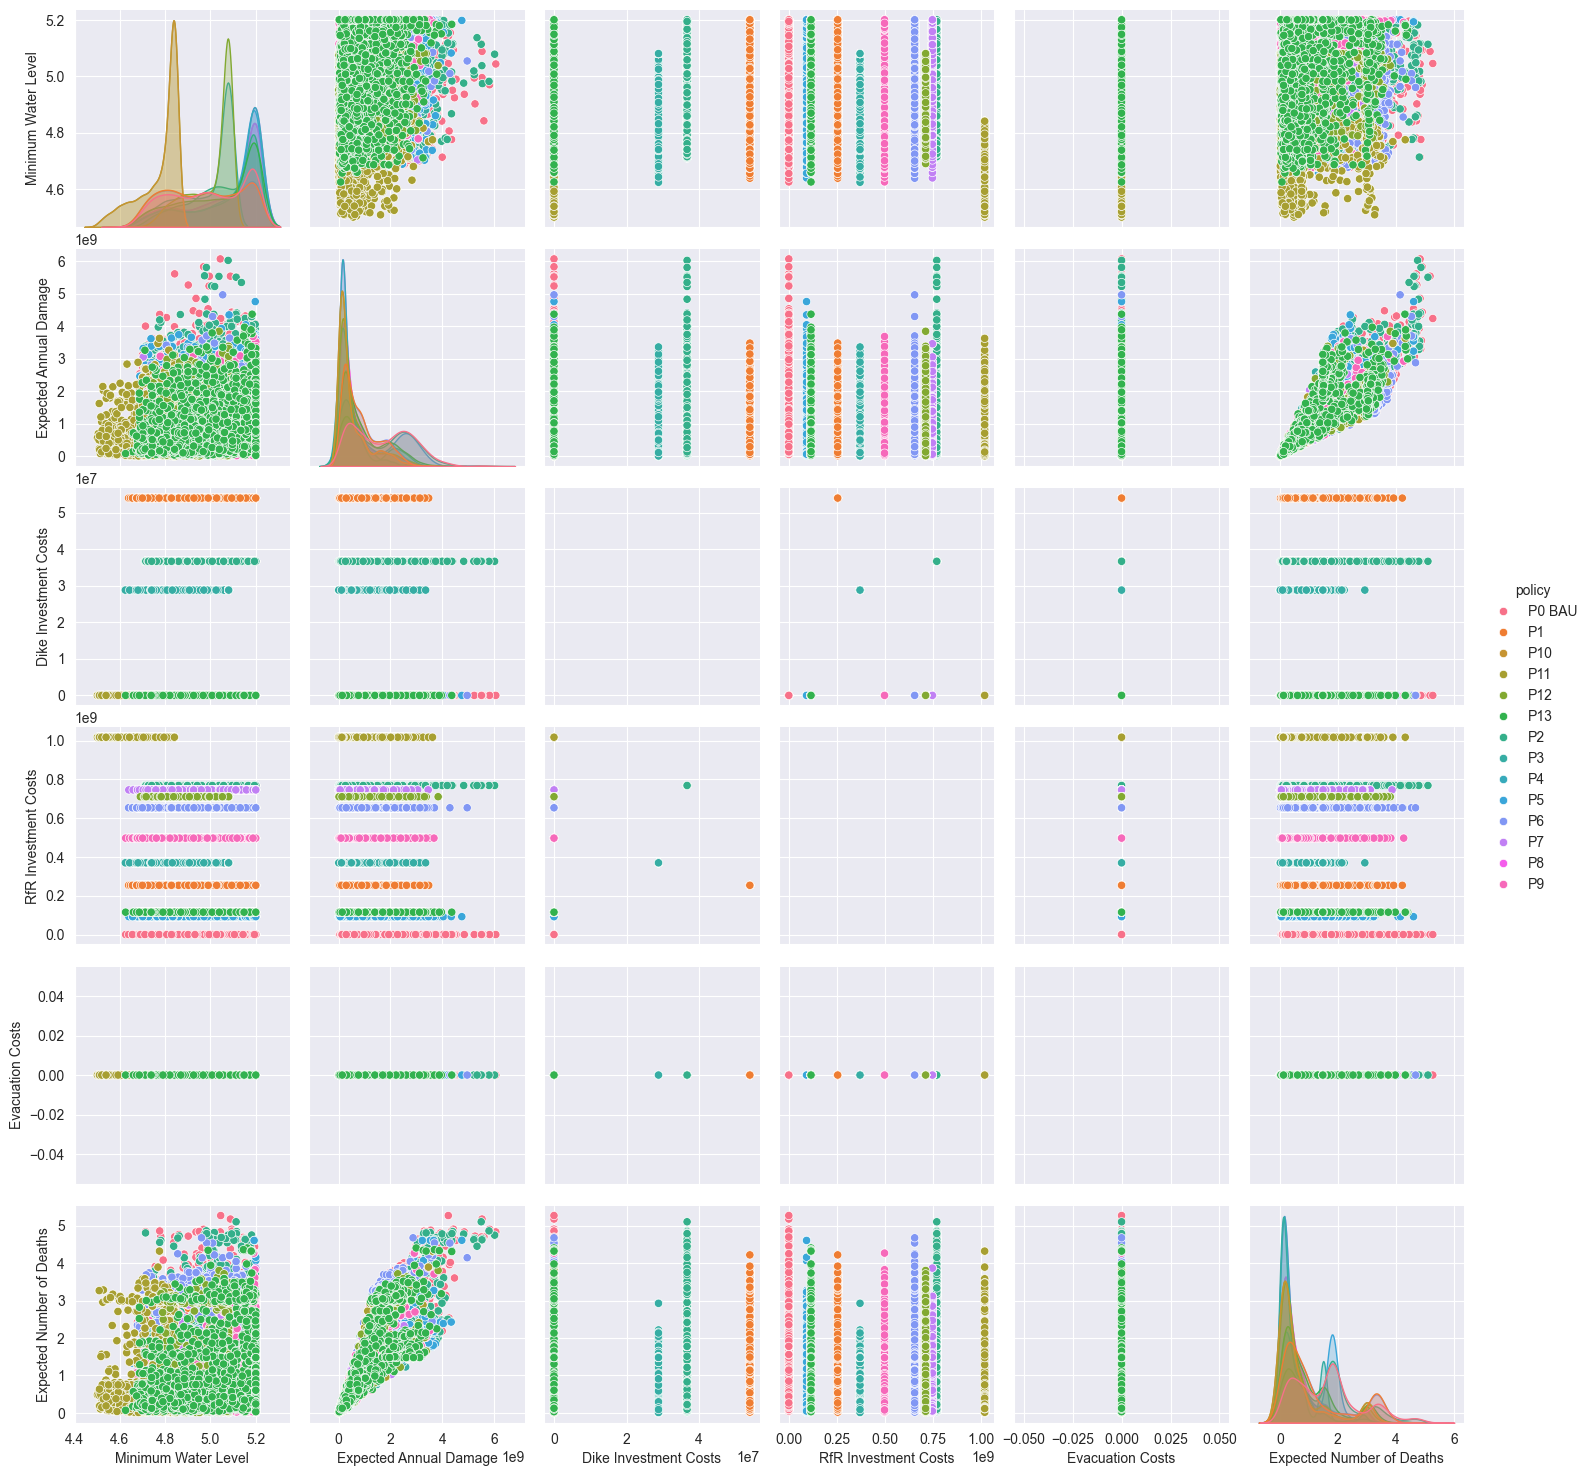

In [31]:
policies_open_exp_2 = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_open_exp_2

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig("Open exploration policies's outcome vs outcome BAU")

In [32]:
experiments.dtypes

A.1_Bmax               float64
A.1_Brate             category
A.1_pfail              float64
A.2_Bmax               float64
A.2_Brate             category
A.2_pfail              float64
A.3_Bmax               float64
A.3_Brate             category
A.3_pfail              float64
A.4_Bmax               float64
A.4_Brate             category
A.4_pfail              float64
A.5_Bmax               float64
A.5_Brate             category
A.5_pfail              float64
discount rate 0       category
discount rate 1       category
discount rate 2       category
0_RfR 0                  int64
0_RfR 1                  int64
0_RfR 2                  int64
1_RfR 0                  int64
1_RfR 1                  int64
1_RfR 2                  int64
2_RfR 0                  int64
2_RfR 1                  int64
2_RfR 2                  int64
3_RfR 0                  int64
3_RfR 1                  int64
3_RfR 2                  int64
4_RfR 0                  int64
4_RfR 1                  int64
4_RfR 2 

In [33]:
#RfR should be 0 or 1, so we can convert it to boolean
for col in experiments.columns:
    if 'RfR' in col:
        experiments[col] = experiments[col].astype(bool)

# Dike heightening should float
for col in experiments.columns:
    if 'DikeIncrease' in col:
        experiments[col] = experiments[col].astype(float)

experiments.dtypes

A.1_Bmax               float64
A.1_Brate             category
A.1_pfail              float64
A.2_Bmax               float64
A.2_Brate             category
A.2_pfail              float64
A.3_Bmax               float64
A.3_Brate             category
A.3_pfail              float64
A.4_Bmax               float64
A.4_Brate             category
A.4_pfail              float64
A.5_Bmax               float64
A.5_Brate             category
A.5_pfail              float64
discount rate 0       category
discount rate 1       category
discount rate 2       category
0_RfR 0                   bool
0_RfR 1                   bool
0_RfR 2                   bool
1_RfR 0                   bool
1_RfR 1                   bool
1_RfR 2                   bool
2_RfR 0                   bool
2_RfR 1                   bool
2_RfR 2                   bool
3_RfR 0                   bool
3_RfR 1                   bool
3_RfR 2                   bool
4_RfR 0                   bool
4_RfR 1                   bool
4_RfR 2 

In [34]:
outcomes_df = pd.DataFrame(outcomes)

experiments_df = pd.DataFrame(experiments)

cleaned_experiments = experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)

## 2. PRIM - Amaryllis <a class="anchor" id="section_2"></a>

### Selected policies against MWL <a class="anchor" id="section_2_2"></a>

In the first iteration we will focus on minimum water level exclusively to identify worst case scenarios

In [35]:
# === Define target for PRIM ===
target = (
    (outcomes['Minimum Water Level'] < 5) )

In [36]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

12986
28000
[False  True]


In [37]:
# === Run PRIM with cleaning the experiments===
prim_alg = prim.Prim(cleaned_experiments, target, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 28000 points remaining, containing 12986 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.14285714285714285, coverage: 0.30802402587401817, density: 1.0 restricted_dimensions: 1


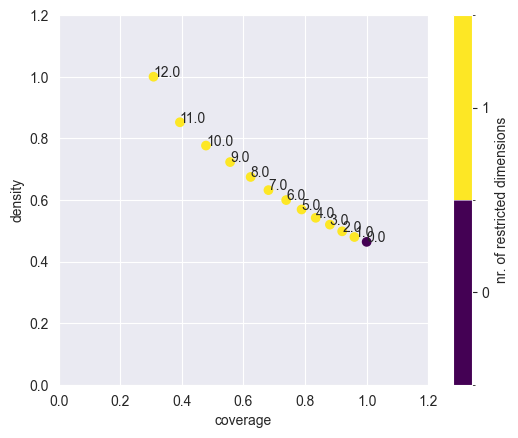

In [38]:
box1.show_tradeoff(annotated=True)
plt.show()

Choose a box that has moderate to high coverage (which means it captures many of the good cases, in this case of the worst-case scenario)
And high density


coverage        0.834668
density         0.541950
id              4.000000
k           10839.000000
mass            0.714286
mean            0.541950
n           20000.000000
res_dim         1.000000
Name: 4, dtype: float64

                                                   box 4  \
                                                     min   
policy  {P12, P0 BAU, P1, P2, P13, P8, P3, P6, P10, P11}   

                                                                         \
                                                     max       qp value   
policy  {P12, P0 BAU, P1, P2, P13, P8, P3, P6, P10, P11}  9.962793e-109   

                 
       qp value  
policy      NaN  



/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'P12', 'P0 BAU', 'P1', 'P2', 'P13', 'P8', 'P3', 'P6', 'P10', 'P11'}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'P12', 'P0 BAU', 'P1', 'P2', 'P13', 'P8', 'P3', 'P6', 'P10', 'P11'}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


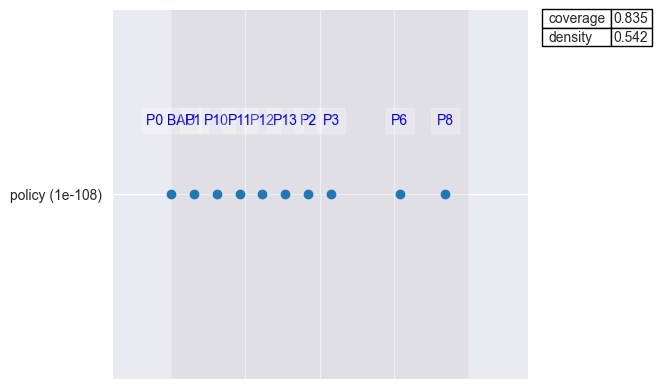

In [39]:
point = 4 # I think 4 or 5

#inspect this box
box1.inspect(point)
box1.inspect(point, style = 'graph')
plt.show()

Here explain the outcomes of the box:
This shows that policy 3, 4 and 5 are bad outcomes for the transport company as the water-level drops below 4.5m. Policy 4 and 5 were considered in the first debate, so this is something the transport company needs to avoid.

Now, we resample to check the robustness of the box. This is done by applying the box's contraints to resampled or shuffled versions of the data. Hereby we can see how much the box's performance was due to overfitting. If the resampled box still shows high coverage and density, the pattern is likely real and stable

In [40]:
box1.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
policy,100.0,100.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.1_pfail,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.2_pfail,0.0,0.0
A.3_Bmax,0.0,0.0
A.3_Brate,0.0,0.0
A.3_pfail,0.0,0.0


What the results of the resampling tells us is that the Policy variable is very robust. This constraint is always part of high-performing boxes in resampled data. This confirms the highly significant quasi p-values in the previous figure. Rest is not robust I think, so the other variables can be safely ignored when interpreting the results.

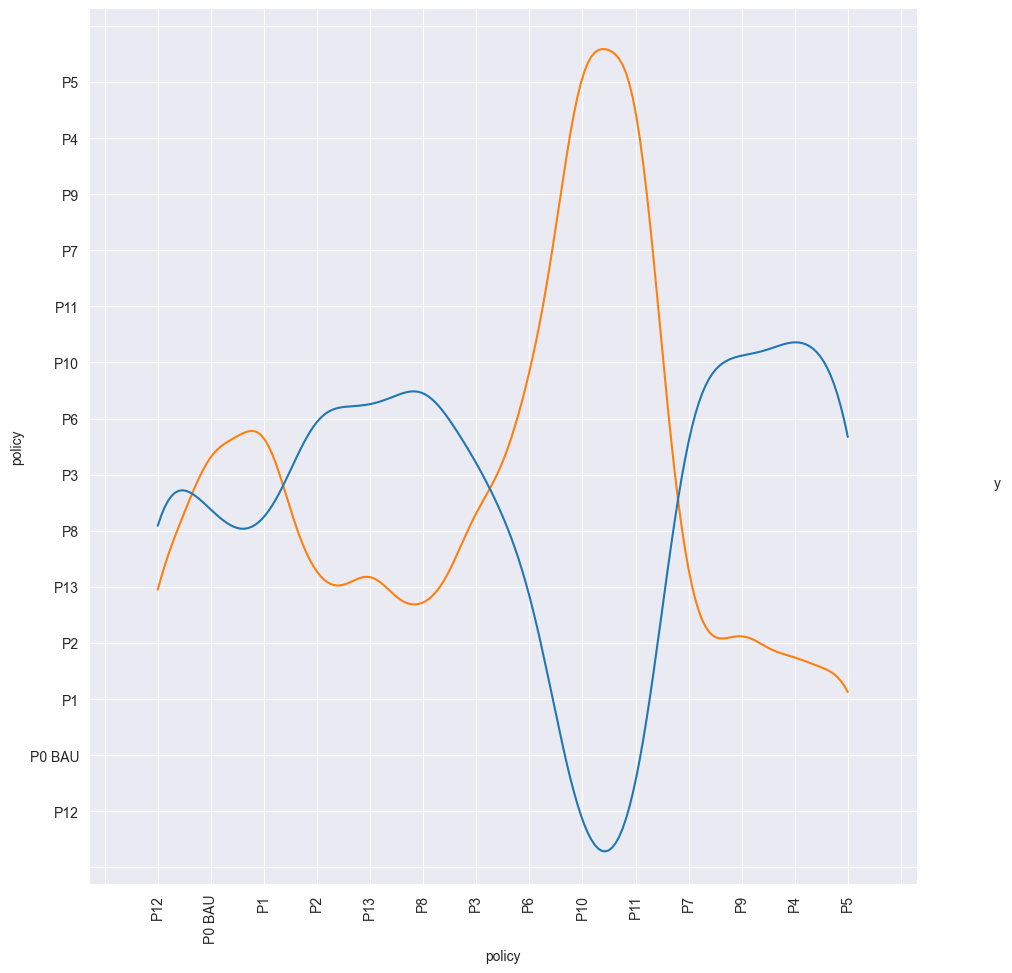

In [41]:
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

The pair-wise scatterplot shows in orange the cases of interest and in blue the cases of not interest. The red square indicates the identified box limits for each pair of parameters.

In the next step, the results are visualized using dimensional stacking.

[MainProcess/INFO] model dropped from analysis because only a single category
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


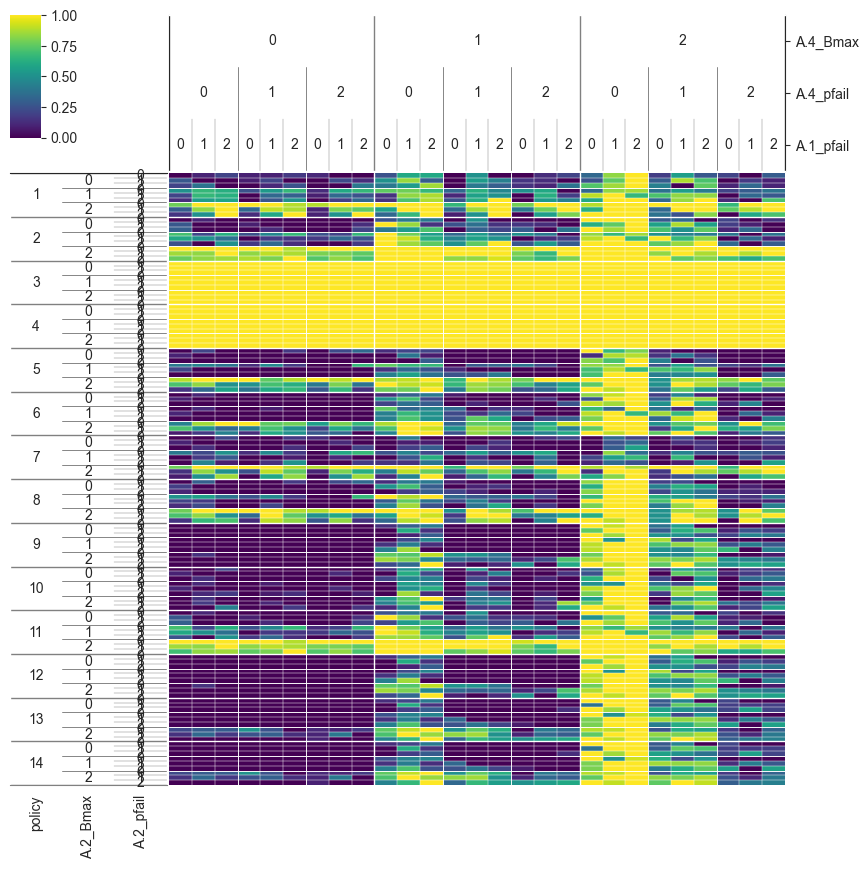

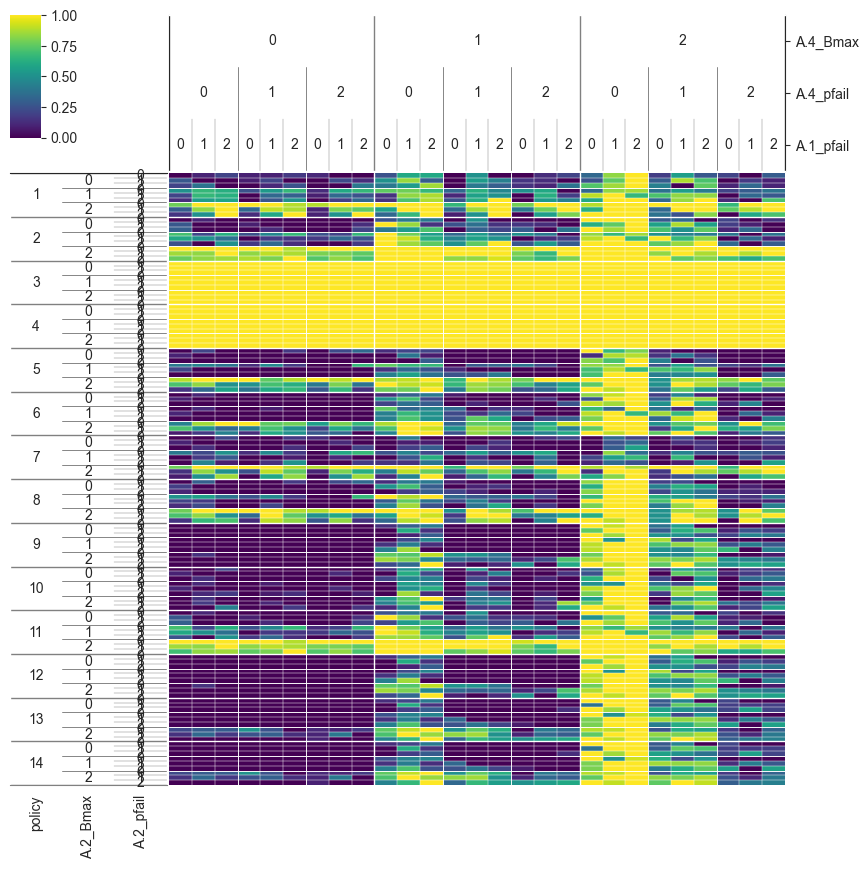

In [42]:
from ema_workbench.analysis import dimensional_stacking
dimensional_stacking.create_pivot_plot(cleaned_experiments, target)

# Other stuff/ questions

- What should we do with the results of BAU?
- Difference between cleaned experiments and experiments in PRIM?
- Why does PRIM make such big jumps? Something with peel_alpha?
- 2_RfR is removed by PRIM as it does not change, what does this mean?


Later: 
- Interpret all graphs together
- Write our pretty report